In [16]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from pydantic import BaseModel, Field
import operator

In [17]:
load_dotenv()  # Load environment variables from .env file
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0) # For strutured output

In [18]:
class EvaluationSchema(BaseModel):
    feedback: str = Field(description="Detailed feedback on the essay")
    score: int = Field(description="Score out of 10", ge=0, le=10)

In [19]:
structured_llm = llm.with_structured_output(EvaluationSchema)

In [20]:
essay = """
The Future Is Now: How India Can Lead in the Age of AI

Artificial Intelligence in India
Artificial Intelligence (AI) is increasingly becoming a part of our daily lives, influencing services, business decisions, and human interaction with technology.

Opportunities in India
India has a robust digital ecosystem with over 800 million internet users and a strong fintech infrastructure.
Initiatives like Digital India, ONDC, and Aadhaar provide a foundation for digital governance.
The challenge lies in aligning current systems with AI capabilities to realize potential transformations.
Future-Ready Workforce
The impact of AI on jobs is significant but not apocalyptic; it will lead to the creation of new roles, particularly in:

Data science
Machine learning operations
Ethical AI compliance
AI integration in industries like healthcare and agriculture
Focus on up-skilling and re-skilling, especially in Tier II and Tier III cities, is critical to ensure equitable benefits from AI advancements.

Educational and Research Evolution
A shift towards an interdisciplinary approach in AI education is needed, combining technology, ethics, policy, and human behavior.
AI education needs to be democratized to reach schools and support diverse research beyond elite institutions.
International collaboration can help India stay competitive in the knowledge economy.
Indigenous and Inclusive AI Journey
India's diversity offers an advantage for AI development:

Custom AI solutions can address issues in Indian languages, rural healthcare, local governance, and agriculture.
Support for indigenous start-ups and public projects to innovate with contextual applicability is crucial.
Strategic Opportunity
India stands at a strategic crossroads. To become a leader in inclusive, ethical AI innovation, the nation needs:

Clear policy direction
Capacity development
Investment in research
Sectoral convergence
This is an opportunity for India to lead in the AI domain rather than follow.
"""

In [21]:
prompt = f"Evaluate the language quality of the essay and provide a feedback and assign a score out of 10 \n {essay}"
structured_llm.invoke(prompt)

EvaluationSchema(feedback="The essay presents a clear and structured argument about India's potential to lead in the field of Artificial Intelligence. The language is generally formal and appropriate for an academic or professional audience. However, there are areas for improvement:\n\n1. **Clarity and Depth**: While the essay outlines several key points, some sections could benefit from more detailed explanations. For instance, the mention of initiatives like Digital India and ONDC could include specific examples of their impact on AI development.\n\n2. **Transitions**: The flow between sections could be improved with better transitional phrases. This would help guide the reader through the argument more smoothly.\n\n3. **Variety in Sentence Structure**: The essay tends to use a similar sentence structure throughout, which can make it feel monotonous. Incorporating a mix of short and long sentences could enhance readability and engagement.\n\n4. **Conclusion**: The essay lacks a stron

In [22]:
class EssayState(TypedDict):
    essay: str
    lang_feedback: str
    analysis_feedback: str
    clarity_feedback: str
    overall_feedback: str
    individual_scores: Annotated[list[int], operator.add]  # Remove Field - just use operator.add for list concatenation
    avg_score: float

In [23]:
def evaluate_language(state: EssayState):
    prompt = f"Evaluate the language quality of the essay and provide a feedback and assign a score out of 10 \n {state['essay']}"
    result = structured_llm.invoke(prompt)
    return {'lang_feedback': result.feedback, 'individual_scores': [result.score]}

def evaluate_analysis(state: EssayState):
    prompt = f"Evaluate the depth of analysis in the essay and provide a feedback and assign a score out of 10 \n {state['essay']}"
    result = structured_llm.invoke(prompt)
    return {'analysis_feedback': result.feedback, 'individual_scores': [result.score]}

def evaluate_clarity(state: EssayState):
    prompt = f"Evaluate the clarity and coherence of the essay and provide a feedback and assign a score out of 10 \n {state['essay']}"
    result = structured_llm.invoke(prompt)
    return {'clarity_feedback': result.feedback, 'individual_scores': [result.score]}

def final_evaluation(state: EssayState):
    # summary feedback
    prompt = f'Based on the following feedbacks, provide an overall feedback for the essay:\n Language Feedback: {state["lang_feedback"]}\n Analysis Feedback: {state["analysis_feedback"]}\n Clarity Feedback: {state["clarity_feedback"]}'
    overall_feedback = llm.invoke(prompt).content
    # average score
    avg_score = sum(state['individual_scores']) / len(state['individual_scores'])
    return {'overall_feedback': overall_feedback, 'avg_score': avg_score}

In [24]:
graph = StateGraph(EssayState)

graph.add_node('evaluate_language', evaluate_language)
graph.add_node('evaluate_analysis', evaluate_analysis)
graph.add_node('evaluate_clarity', evaluate_clarity)
graph.add_node('final_evaluation', final_evaluation)

graph.add_edge(START, 'evaluate_language')
graph.add_edge(START, 'evaluate_analysis')
graph.add_edge(START, 'evaluate_clarity')

graph.add_edge('evaluate_language', 'final_evaluation')
graph.add_edge('evaluate_analysis', 'final_evaluation')
graph.add_edge('evaluate_clarity', 'final_evaluation')
graph.add_edge('final_evaluation', END)

workflow = graph.compile()

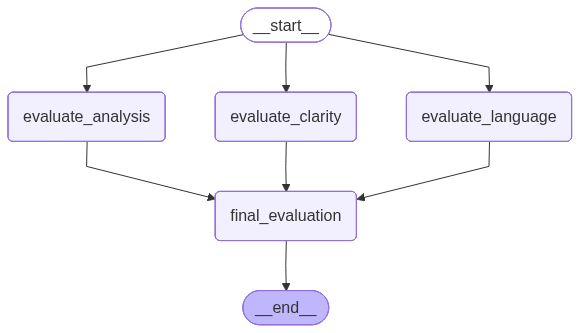

In [25]:
workflow

In [26]:
initial_state = {
    'essay': essay,
    'individual_scores': []  # Initialize empty list for score accumulation
}

result = workflow.invoke(initial_state)
print(f"Overall Score: {result['avg_score']:.2f}/10\n")
print(f"Individual Scores: {result['individual_scores']}\n")
print("=" * 60)
print("OVERALL FEEDBACK:")
print("=" * 60)
print(result['overall_feedback'])

Overall Score: 7.33/10

Individual Scores: [7, 8, 7]

OVERALL FEEDBACK:
**Overall Feedback for the Essay:**

The essay presents a well-structured and coherent argument regarding India's potential to lead in the field of Artificial Intelligence (AI). It effectively outlines various critical aspects, including the digital ecosystem, workforce implications, educational needs, and the importance of inclusivity in AI development. The language used is generally formal and appropriate for an academic audience, contributing to the overall clarity of the argument.

However, there are several areas where the essay could be improved to enhance its effectiveness:

1. **Clarity and Conciseness**: While the essay is informative, some sentences could be streamlined for better readability. Simplifying complex phrases will help maintain the reader's engagement and ensure that the key points are easily understood.

2. **Transitions and Flow**: The flow between sections could be improved with the use of 